### Bayesian Data Analysis, 3rd edition
##  Chapter 5, demo 1

Hierarchical model for Rats experiment (BDA3, p. 102).

In [1]:
import numpy as np
from scipy.stats import beta
from scipy.special import gammaln

%matplotlib inline
import matplotlib.pyplot as plt

import os, sys
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

import plot_tools

plt.rc('font', size=12)
plt.style.use(plot_tools.custom_styles['gray_background'])

Rat data:

In [2]:
y = np.array([
     0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
     1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
     5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])
M = len(y)

### Overview and separate and pooled models

* $y$ is the number of rats that developed a tumour for a given experiment.
* $n$ is the number of rats in the experiment.
* We can thus think of $\theta$ as the probability of a tumour in a given experiment.

We can thus model the outcome for the $j$ experiment as a binomial distribution:

$$y_j \mid n_j, \theta_j \sim \text{Bin}(y_j \mid n_j, \theta_j)$$

We can choose to model as separate, pooled or hierarchical.

#### Separate model

As $\theta$ represents a probability it is confined to the interval $[0, 1]$ and if we place a uniform prior over $\theta$ the posterior for the $j$th experiment is:

$$\theta_j \mid n_j, y_j \sim \text{Beta}(y_j + 1, n_j - y_j + 1)$$

and so in this way we estimate as many posterior distributions as experiments (here, 70, excluding the last/"current" experiment).

#### Pooled model

This model just estimates a single posterior using the totals of $y$ and $n$ across all experiments.

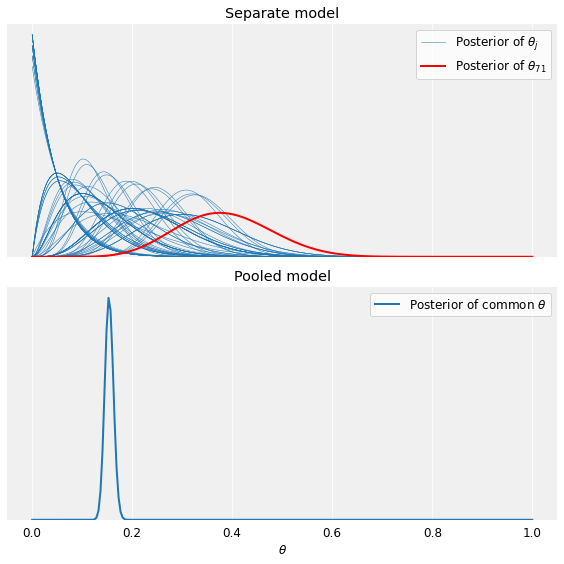

In [3]:
# plot the separate and pooled models
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
x = np.linspace(0, 1, 250)

# separate model (don't use last experiment)
ax = axes[0]
lines = ax.plot(
    x,
    beta.pdf(x[:,None], y[:-1] + 1, n[:-1] - y[:-1] + 1),
    color='C0',
    linewidth=0.5
)
# highlight the last line
lines[-1].set_linewidth(2)
lines[-1].set_color('r')
ax.legend(
    (lines[0], lines[-1]),
    (r'Posterior of $\theta_j$',
     r'Posterior of $\theta_{71}$')
)
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero
ax.set_yticks(())
ax.set_title('Separate model')

# pooled (why using last experiment? mistake?)
ax = axes[1]
ax.plot(
    x,
    beta.pdf(x, y.sum() + 1, n.sum() - y.sum() + 1),
    linewidth=2,
    label=(r'Posterior of common $\theta$')
)
ax.legend()
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero
ax.set_yticks(())
ax.set_xlabel(r'$\theta$')
ax.set_title('Pooled model')

fig.tight_layout()

### Hierarchical model

In the case of the hierarchical model we model the individual $\theta_j$ parameters as being drawn from a common distribution:

$$\theta_j \sim \text{Beta}(\alpha, \beta)$$

Per equation 5.8 in BDA3 we can compute the marginal log-posterior of the hyperparameters $\alpha$ and $\beta$ for the hierarchical model over a grid of values.

In [4]:
A = np.linspace(0.5, 6, 100)
B = np.linspace(3, 33, 100)

lp = (
  - 5/2 * np.log(A + B[:, None])
  + np.sum(
        gammaln(A + B[:, None])
      - gammaln(A)
      - gammaln(B[:, None])
      + gammaln(A + y[:, None, None])
      + gammaln(B[:, None] + (n - y)[:, None, None])
      - gammaln(A + B[:, None] + n[:, None, None]),
        axis=0
    )
)

# subtract the maximum value to avoid over/underflow in exponentation
lp -= lp.max()
p = np.exp(lp)

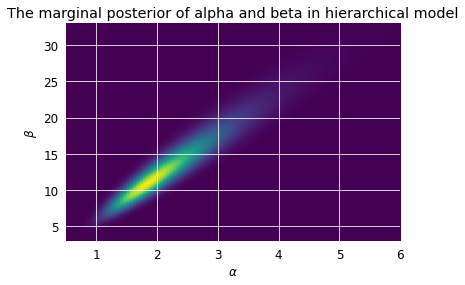

In [5]:
plt.imshow(
    p,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('The marginal posterior of alpha and beta in hierarchical model')
plt.grid('off')

### Posterior predictive for $\theta$

Sample from posterior grid of $\alpha$ and $\beta$ and plot the "distributions of distributions": $\text{Beta}(\alpha, \beta)$.

Note that averaging many samples from $p(\alpha, \beta \mid y)$ gives the posterior predictive distribution for a new $\theta_j$.

In [6]:
nsamp = 1000
samp_indices = np.unravel_index(
    np.random.choice(p.size, size=nsamp, p=p.ravel()/p.sum()),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (np.random.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (np.random.rand(nsamp) - 0.5) * (B[1]-B[0])

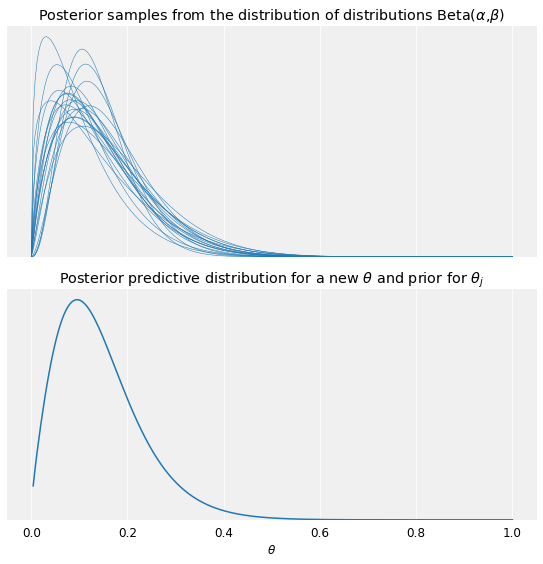

In [7]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

ax = axes[0]
ax.plot(
    x,
    beta.pdf(x[:,None], samp_A[:20], samp_B[:20]),
    linewidth=0.5,
    color='C0'
)
ax.set_yticks(())
ax.set_title(
    r'Posterior samples from the distribution of distributions '
    r'Beta($\alpha$,$\beta$)'
)
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

ax = axes[1]
plt.plot(x, np.mean(beta.pdf(x, samp_A[:,None], samp_B[:,None]), axis=0))
ax.set_yticks(())
ax.set_xlabel(r'$\theta$')
ax.set_title(
    r'Posterior predictive distribution for a new $\theta$ '
    r'and prior for $\theta_j$'
)
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

fig.tight_layout()

### Compare separate and hierarchical model

We plot (as above) a sample of the posteriors of $\theta_j$ for the separate model and for the hierarchical model.

Note that for the hierarchical model the marginal posteriors for $\theta_j$ are narrower than in the separate model case due to the borrowed information from the other $\theta_j$'s.

To actually get the samples from the posterior $\theta_j$'s in the hierarchical model we use the samples from the posterior for $p(\alpha, \beta \mid y)$ (i.e. per ancestral sampling) and average over these for each $\theta$.

In [16]:
beta.pdf(
        x[:, None],
        y[7::7] + samp_A[:,None,None],
        n[7::7] - y[7::7] + samp_B[:,None,None]
).shape

(1000, 250, 10)

^^^ this has shape `(num_samples, x_grid, num_thetas)` where

* the 1000 is the number of samples from the posteriors of $\alpha$ and $\beta$,
* the 250 is the coarseness of the x grid we are ploting $\theta$ over and 
* the 10 comes from choosing every 7th $\theta_j$ to plot.

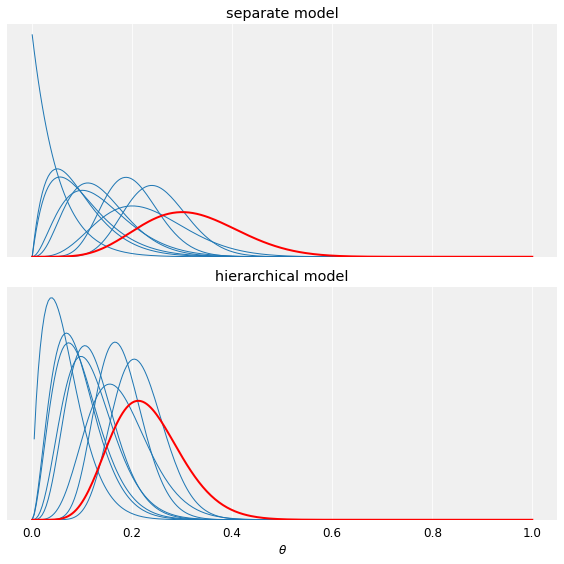

In [19]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
x = np.linspace(0, 1, 250)

ax = axes[0]
# note that for clarity only every 7th distribution is plotted
lines = ax.plot(
    x,
    beta.pdf(x[:,None], y[7:-1:7] + 1, n[7:-1:7] - y[7:-1:7] + 1),
    color='C0',
    linewidth=1
)
# highlight the last line
lines[-1].set_linewidth(2)
lines[-1].set_color('r')
ax.set_yticks(())
ax.set_title('separate model')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

ax = axes[1]
# note that for clarity only every 7th distribution is plotted
lines = ax.plot(
    x,
    np.mean(
        beta.pdf(
            x[:, None],
#             y[7::7] + samp_A[:,None,None],
#             n[7::7] - y[7::7] + samp_B[:,None,None]
            y[7:-1:7] + samp_A[:, None, None],
            n[7:-1:7] - y[7:-1:7] + samp_B[:, None, None]
        ),
        axis=0
    ),
    color='C0',
    linewidth=1,
)
# highlight the last line
lines[-1].set_linewidth(2)
lines[-1].set_color('r')
ax.set_yticks(())
ax.set_xlabel(r'$\theta$')
ax.set_title('hierarchical model')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

fig.tight_layout()